#Model definition





In [ ]:
import numpy as np
import torch
import torch.nn as nn

In [ ]:
!git clone https://github.com/PepeCamposGarcia/PINNs.git

The problem we are aiming to solve is the Burgers equation with initial and boundary conditions:
$$
\begin{cases}
u_t + u  u_x - \left(\frac{0.01}{\pi}\right) u_{xx} = 0, & x \in [-1,1], \, t \in [0,1], \\
u(x, 0) = -\sin(\pi x),  \\
u(-1, t) = u(1, t) = 0,
\end{cases}
$$

In [ ]:
class SinusoidalActivation(nn.Module):
  def forward(self,x):
    return torch.sin(2 * np.pi * x)

In [ ]:
class Burgers1D(nn.Module):

############################### NET ARCHITECTURE ###############################

  def __init__(self, num_neurons, num_layers, nu):
    self.nu = nu

    super(Burgers1D, self).__init__()
    self.num_neurons = num_neurons
    self.num_layers = num_layers

### Imput layer, fully connected to the first hidden layer, sinusoidal activation
### function for the dismiss of local minima

    layer_list = [nn.Linear(2, self.num_neurons)]
    layer_list.append(SinusoidalActivation())

### Loop for the description of the hidden layers: fully connected layers,
### hiperbolic tangent activation function

    for _ in range (self.num_layers - 2):
      layer_list.append(nn.Linear(self.num_neurons, self.num_neurons))
      layer_list.append(nn.Tanh())

### Output layer, 1 output u

    layer_list.append(nn.Linear(self.num_neurons, 1))
    self.layers = nn.ModuleList(layer_list)


################## FEED-FORWARD PROPAGATION, OUTPUTS ###########################

  def forward(self, x, t):
     """
        Params:
        x - array of shape (N, 1), input x coordinates
        t - array of shape (N, 1), input time coordinate
        Returns:
        u - tensor of shape (N, 1), output x-velocity
        f - PDE evaluation of shape (N, 1)

     """
     x = torch.tensor(x, dtype=torch.float32, requires_grad=True)
     t = torch.tensor(t, dtype=torch.float32, requires_grad=True)

     input_data = torch.hstack([x, t])

     out = input_data

     for layer in self.layers:
      out = layer(out)

     u = out[:] # (N, 1) each

     u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
     u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
     u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

        # Evaluate PDE

     f = u_t + u * u_x - self.nu * u_xx # (N, 1)


     return u, f

## Loss function

In [ ]:
##################### LOSS FUNCTION DESIGN #####################################

class Burgers1DLoss(nn.Module):
  def __init__(self):
    super().__init__()
    self.mse = nn.MSELoss()

  def forward(self, u_init, u_net_init, u_net_BC, f):

     L_init = self.mse(u_init, u_net_init)
     L_boundary = self.mse(u_net_BC, torch.zeros_like(u_net_BC))
     L_pde  = self.mse(f, torch.zeros_like(f))

     return L_init + L_boundary + L_pde

## Data loading

In [ ]:
import scipy

In [ ]:
def boundary_indices(T, N):
    """
    Returns a boolean mask marking the boundary spatial points for all timesteps
    Params:
    N - # of data samples (space locations) in problem
    T - # of timesteps
    Return:
    nd-array of shape (N*T, )
    """
    # Create grid for one timestep
    # Data is a 100 x 256 matrix
    # This function creates a boolean mask to identify every point with x=1 or x=-1


    grid = np.zeros((100, 256))

    # Set boundary to 1
    grid[:, 0] = 1
    grid[:, -1] = 1

    grid_in = grid.flatten().reshape(-1,1)

    # Flatten final grid into column vector to be used in training
    boundary_positions = grid_in.astype(bool)

    return boundary_positions


In [ ]:
def init_indices(T, N):
    """
    Returns a boolean mask marking the initial condition points
    Params:
    N - # of data samples (space locations) in problem
    T - # of timesteps
    Return:
    nd-array of shape (N*T, )
    """
    # Create grid for one timestep
    # Data consists of a 100 x 256 matrix
    # This function creates a boolean mask to identify every point with t=0


    grid = np.zeros((100, 256))

    # Set boundary to 1

    grid[0, :] = 1

    grid_init_in = grid.flatten().reshape(-1,1)

    # Flatten final grid into column vector to be used in training
    init_positions = grid_init_in.astype(bool)

    return init_positions


In [ ]:
import csv

In [ ]:
def data_loading () :
  x=torch.linspace(-1,1,256)
  t=torch.linspace(0,1,100)
  N, T = x.shape[0], t.shape[0]
  XX,TT = torch.meshgrid(x,t)
  XX = XX.transpose(1,0)
  TT = TT.transpose(1,0)

  x_in = XX.flatten().reshape(-1, 1)  # NT x 1
  t_in = TT.flatten().reshape(-1, 1)  # NT x 1

  return x, t, XX, TT, x_in, t_in, (T, N)

#Training set

In [ ]:
x, t, XX, TT, x_in, t_in, (T, N) = data_loading ()
# For boundary an initial points, it is in the variables idx_b_train and
# idx_i_train where we choose how many of them will be used in training,
# in this case 50 of each are selected

# Boundary training points
idx_b = boundary_indices(T, N)
x_boundary = x_in[idx_b, :]
t_boundary = t_in[idx_b, :]
idx_b_train = np.random.choice(x_boundary.shape[0], 50, replace=False)
x_b_train = x_boundary[idx_b_train].reshape(-1,1)
t_b_train = t_boundary[idx_b_train].reshape(-1,1)


# Initial training points
idx_i = init_indices(T ,N)
x_init = x_in[idx_i, :]
idx_i_train = np.random.choice(x_init.shape[0], 50, replace=False)
x_i_train = x_init[idx_i_train].reshape(-1,1)
t_i_train = torch.zeros_like(x_i_train).reshape(-1,1)

u_init = -torch.sin(torch.pi*x_i_train)
u_init = torch.tensor(u_init, dtype = torch.float32)
u_init = u_init.reshape(-1,1)


# Collocation points
# Choose fraction of the total points to be used in training set as collocation points.
# In this case a 40% of the total 26500 are used
samples = int(round(N * T * 0.40))

idx = np.random.choice(x_in.shape[0], samples, replace=False)
x_train = x_in[idx, :]
t_train = t_in[idx, :]

##Training algorithm

In [ ]:
from tqdm import tqdm

In [ ]:
def main(num_neurons, num_layers, epochs):
    """
    Params:
    num_neurons - int, # of hidden units for each neural network layer
    num_layers - int, # of neural network layers
    epochs - int, # of training epochs

    """
    nu = 0.01/torch.pi

    PINN_model = Burgers1D(num_neurons=num_neurons, num_layers=num_layers, nu=nu)
    criterion = Burgers1DLoss()

    optimizer = torch.optim.LBFGS(PINN_model.parameters(), line_search_fn='strong_wolfe')

    def closure():
        """Define closure function to use with LBFGS optimizer"""
        optimizer.zero_grad()   # Clear gradients from previous iteration

        u_net, f = PINN_model(x_train, t_train)
        u_net_BC, g = PINN_model(x_b_train, t_b_train)
        u_net_init, h = PINN_model(x_i_train, t_i_train)

        loss = criterion(u_init, u_net_init, u_net_BC, f)

        loss.backward() # Backprogation
        return loss

    def training_loop(epochs):
        """Run training loop"""


        for i in tqdm(range(epochs), desc='Training epochs: '):


          optimizer.step(closure)
          loss = closure().item()

    training_loop(epochs=epochs)
    torch.save(PINN_model.state_dict(), 'model_name.pth')
    return



Running the following cell will start the network training, and generate a .pth file named 'model_name.pth', with the width and depth specified in 'num_neurons' and 'num_layers', and trained over 'epochs' iterations. The training set used was constructed in the previous section.

In [ ]:
if __name__ == '__main__':
    main(num_neurons=num_neurons, num_layers=num_layers, epochs=epochs)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd

##Representation functions

In [ ]:
def plot_loss_from_csv(file_path):
    epochs = []
    losses = []

    with open(file_path, 'r', newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)
        for row in reader:
            epoch, loss = map(float, row)
            epochs.append(epoch)
            losses.append(loss)

    plt.plot(epochs, losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

In [ ]:
def plot3D(x,t,y):
  x_plot =x.squeeze(1)
  t_plot =t.squeeze(1)
  X,T= torch.meshgrid(x_plot,t_plot)
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('u(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('u(x,t)')
  plt.show()


def plot3D_Matrix(x,t,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('u(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('u(x,t)')
  plt.show()


## Model loading
In this section, the same network is trained over different numbers of iterations, ranging from 1 to 10000 epochs, with the purpose of quatifying the impact this has on the accuracy obtained by the model.

In [ ]:
def load_saved_model_1(num_layers, num_neurons):

    nu = 0.01

    # load saved state_dict
    PINN_model = Burgers1D(num_neurons=num_neurons, num_layers=num_layers, nu=nu)
    PINN_model.load_state_dict(torch.load('/content/PINNs/Models_Data_Figures/BURGERS/Burgers_Epochs/Models/1epoch.pth'))
    PINN_model.eval() # Set model to evaluation mode
    return PINN_model

In [ ]:
def load_saved_model_5(num_layers, num_neurons):

    nu = 0.01

    # load saved state_dict
    PINN_model = Burgers1D(num_neurons=num_neurons, num_layers=num_layers, nu=nu)
    PINN_model.load_state_dict(torch.load('/content/PINNs/Models_Data_Figures/BURGERS/Burgers_Epochs/Models/5epochs.pth'))
    PINN_model.eval() # Set model to evaluation mode
    return PINN_model

In [ ]:
def load_saved_model_50(num_layers, num_neurons):

    nu = 0.01

    # load saved state_dict
    PINN_model = Burgers1D(num_neurons=num_neurons, num_layers=num_layers, nu=nu)
    PINN_model.load_state_dict(torch.load('/content/PINNs/Models_Data_Figures/BURGERS/Burgers_Epochs/Models/50epochs.pth'))
    PINN_model.eval() # Set model to evaluation mode
    return PINN_model

In [ ]:
def load_saved_model_200(num_layers, num_neurons):

    nu = 0.01

    # load saved state_dict
    PINN_model = Burgers1D(num_neurons=num_neurons, num_layers=num_layers, nu=nu)
    PINN_model.load_state_dict(torch.load('/content/PINNs/Models_Data_Figures/BURGERS/Burgers_Epochs/Models/200epochs.pth'))
    PINN_model.eval() # Set model to evaluation mode
    return PINN_model

In [ ]:
def load_saved_model_1000(num_layers, num_neurons):

    nu = 0.01

    # load saved state_dict
    PINN_model = Burgers1D(num_neurons=num_neurons, num_layers=num_layers, nu=nu)
    PINN_model.load_state_dict(torch.load('/content/PINNs/Models_Data_Figures/BURGERS/Burgers_Epochs/Models/1000epochs.pth'))
    PINN_model.eval() # Set model to evaluation mode
    return PINN_model

In [ ]:
def load_saved_model_5000(num_layers, num_neurons):

    nu = 0.01

    # load saved state_dict
    PINN_model = Burgers1D(num_neurons=num_neurons, num_layers=num_layers, nu=nu)
    PINN_model.load_state_dict(torch.load('/content/PINNs/Models_Data_Figures/BURGERS/Burgers_Epochs/Models/5000epochs.pth'))
    PINN_model.eval() # Set model to evaluation mode
    return PINN_model

In [ ]:
def load_saved_model_10000(num_layers, num_neurons):

    nu = 0.01

    # load saved state_dict
    PINN_model = Burgers1D(num_neurons=num_neurons, num_layers=num_layers, nu=nu)
    PINN_model.load_state_dict(torch.load('/content/PINNs/Models_Data_Figures/BURGERS/Burgers_Epochs/Models/10000epochs.pth'))
    PINN_model.eval() # Set model to evaluation mode
    return PINN_model

In [ ]:
model_1epochs = load_saved_model_1(num_layers = 5, num_neurons = 30)
model_5epochs = load_saved_model_5(num_layers = 5, num_neurons = 30)
model_50epochs = load_saved_model_50(num_layers = 5, num_neurons = 30)
model_200epochs = load_saved_model_200(num_layers = 5, num_neurons = 30)
model_1000epochs = load_saved_model_1000(num_layers = 5, num_neurons = 30)
model_5000epochs = load_saved_model_5000(num_layers = 5, num_neurons = 30)
model_10000epochs = load_saved_model_10000(num_layers = 5, num_neurons = 30)

#Model evaluation

In [ ]:
#MODEL EVALUATION

#u_in1 is a tensor containing the predicted solution across the spatio-temporal domain
#fn2 is a tensor containing the evaluation of the Burgers equation
#UUn1 is a reshape of the solution for its representation
#n1 refers to the number of iterations over which the model was trained

u_in1, f7 = model_1epochs(x_in, t_in)
UU1 = u_in1.reshape(T, N).detach().transpose(1,0)

u_in5, f6 = model_5epochs(x_in, t_in)
UU5 = u_in5.reshape(T, N).detach().transpose(1,0)

u_in50, f1 = model_50epochs(x_in, t_in)
UU50 = u_in50.reshape(T, N).detach().transpose(1,0)

u_in200, f2 = model_200epochs(x_in, t_in)
UU200 = u_in200.reshape(T, N).detach().transpose(1,0)

u_in1000, f3 = model_1000epochs(x_in, t_in)
UU1000 = u_in1000.reshape(T, N).detach().transpose(1,0)

u_in5000, f4 = model_5000epochs(x_in, t_in)
UU5000 = u_in5000.reshape(T, N).detach().transpose(1,0)

u_in10000, f5 = model_10000epochs(x_in, t_in)
UU10000 = u_in10000.reshape(T, N).detach().transpose(1,0)

In [ ]:
XX_p=XX.detach().transpose(1,0)
TT_p=TT.detach().transpose(1,0)

## Exact solution

In [ ]:
def data_loading_2 ():

  data = scipy.io.loadmat('/content/PINNs/Models_Data_Figures/Data/burgers_equation.mat')
  UU_star = torch.tensor(data['usol']) #        256 x 100
  X_star = data['x']                   #        256 x 1
  t_star = data['t']                   #        100  x 1

  N, T= X_star.shape[0], t_star.shape[0]

  # Column vector transformation  25600 x 1
  u_star_in = UU_star.flatten().reshape(-1, 1)

  return UU_star, u_star_in

In [ ]:
UU_star, u_star_in = data_loading_2 ()

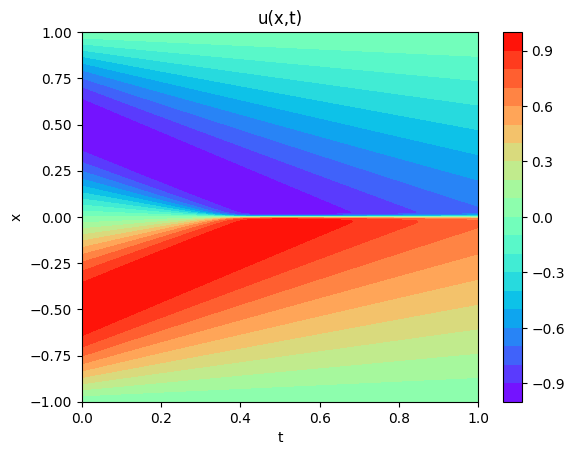

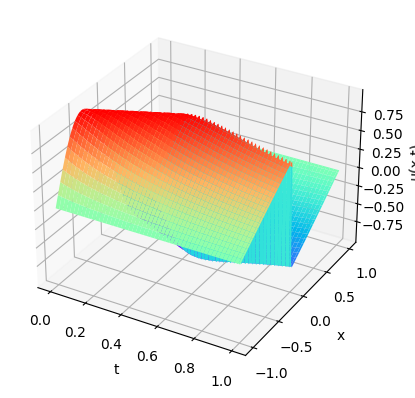

In [ ]:
plot3D_Matrix(XX_p,TT_p,UU_star)



## Accuracy analysis



Root mean squared error

In [ ]:
def rMSE(UU):

    # Initialize array to hold sum of square errors (sse)
    N = UU.shape[0]
    T = UU.shape[1]

    sse = np.zeros(T)

    for i in range(T):
        # Prediction for time i
        sse[i] = ((UU[:,i]-UU_star[:,i])**2).sum()

    # Sum sse over timesteps
    sse = sse.sum()

    # Average sse over all samples and all timesteps to get mean squared error (mse)
    mse = sse / (N * T)

    #R^2 coefficient calculation
    # Find total sum of squares (SSTO)
    ssto = ((u_star_in - u_star_in.mean()) ** 2).sum()
    ssto = ssto.detach()
    R2 = (1 - (sse / ssto))

    return mse, R2.detach()

In [ ]:
# Calculate rmse for each epoch
epoch_list = [50, 200, 1000, 5000, 10000]
U_list = [UU50, UU200, UU1000, UU5000, UU10000]

rmse_list, r2_list = [], []
for i, epoch in enumerate(epoch_list):
    rmse_i, r2_i = rMSE(U_list[i]) #each of shape (1, )
    rmse_list.append(rmse_i)
    r2_list.append(r2_i)

rmse, r2 = np.vstack(rmse_list), np.vstack(r2_list) # # epochs tested, u
rmse_df, r2_df = pd.DataFrame(rmse, columns=['RMSE'], index=epoch_list), pd.DataFrame(r2, columns=['R2'], index=epoch_list)

#Results table
The following table summarizes the results obtained during this section, reflecting the predictions' root mean squared error with respect to the exact solution across all the domain. Greater number of iterations leads to better results.

In [ ]:
df_rmse = pd.concat([rmse_df, r2_df], axis=1)
df_rmse

,RMSE,R2
50,0.000528,0.998602
200,0.000369,0.999023
1000,0.000028,0.999925
5000,0.000011,0.999970
10000,0.000009,0.999976


In [ ]:
df_rmse.to_csv('estudioepochs.csv', index=True)
files.download('estudioepochs.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Previous table graphic representation

In [ ]:
import pandas as pd
from google.colab import files

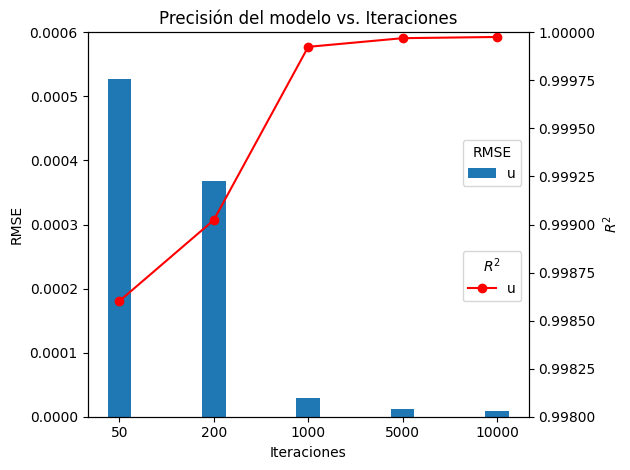

In [ ]:
%matplotlib inline
fig, ax1 = plt.subplots()

n = np.arange(len(epoch_list))  # the label locations
width = 0.25  # the width of the bars

# Plot RMSE
ax1.bar(n, rmse_df['RMSE'], width=width, label='u')

# Plot R2
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(n, r2_df['R2'], label='u', color = 'r', marker='o')
ax2.set_ylim(bottom=0.998, top=1.0)

ax1.legend(loc=(0.85, 0.6), title='RMSE')
ax2.legend(loc=(0.85, 0.3), title='$R^2$')
ax1.set_ylim(bottom=0, top=0.0006)
ax1.set_xticks(n, epoch_list)
ax1.set_xlabel('Iteraciones')
ax1.set_ylabel('RMSE')
ax2.set_ylabel('$R^2$')
ax1.set_title('Precisión del modelo vs. Iteraciones')
plt.tight_layout()
plt.show()

#Graphic representation of the prediction made by the model

In [ ]:
import matplotlib.pyplot as plt

# newfig and savefig functions
plt.rcParams['text.usetex'] = False

def newfig(width, height):
    fig = plt.figure(figsize=(width, height))
    ax = fig.add_subplot(111)
    return fig, ax

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.serif'] = 'DejaVu Sans'
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'
plt.rcParams['font.monospace'] = 'DejaVu Sans'


def savefig(filename, crop = True):
    if crop == True:
#        plt.savefig('{}.pgf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.pdf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.eps'.format(filename), bbox_inches='tight', pad_inches=0)
    else:
#        plt.savefig('{}.pgf'.format(filename))
        plt.savefig('{}.pdf'.format(filename))
        plt.savefig('{}.eps'.format(filename))

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata

<ipython-input-22-6d27fe9158a0>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs0[:, :])


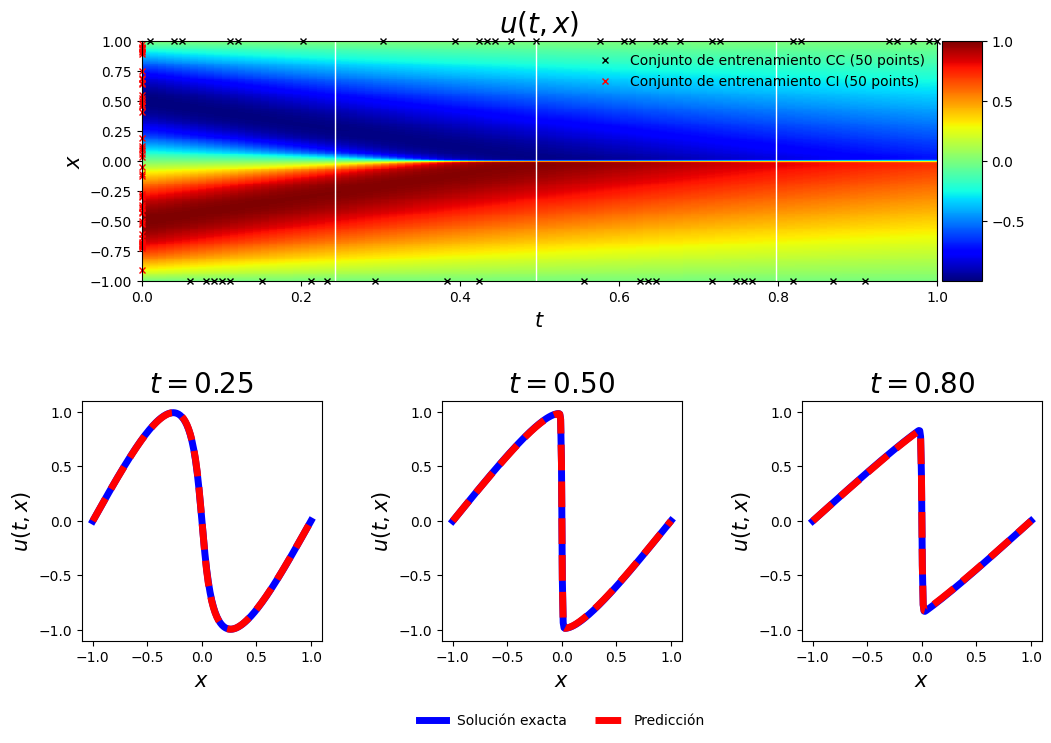

In [ ]:

fig, ax = newfig(12, 8)  # Figure size
ax.axis('off')

##### Row 0: u(t,x) #####
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=0.9, bottom=0.6, left=0.15, right=0.85, wspace=0.2)  # Proportions
ax = plt.subplot(gs0[:, :])

# Show figure
h = ax.imshow(UU10000, interpolation='nearest', cmap='jet',
              extent=[0, t.max().detach().numpy(), x.min(), x.max()],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

# Training dataset representation
ax.plot(t_b_train, x_b_train, 'kx',label='Conjunto de entrenamiento CC (%d points)' % 50, markersize=4, clip_on=False)
ax.plot(t_i_train, x_i_train, 'rx',label='Conjunto de entrenamiento CI (%d points)' % 50, markersize=4, clip_on=False)

# White lines
line = np.linspace(x.min(), x.max(), 2)[:, None]
ax.plot(TT[24, 1] * np.ones((2, 1)), line, 'w-', linewidth=1)
ax.plot(TT[49, 1] * np.ones((2, 1)), line, 'w-', linewidth=1)
ax.plot(TT[79, 1] * np.ones((2, 1)), line, 'w-', linewidth=1)

ax.set_xlabel('$t$', fontsize=15)
ax.set_ylabel('$x$', fontsize=15)
ax.legend(frameon=False, loc='best')
ax.set_title('$u(t,x)$', fontsize=20)  # Font size

#### Row 1: u(t,x) slices #####
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=0.5, bottom=0.1, left=0.1, right=0.9, wspace=0.5)  # Proportion adjustment

# t = 0.25
ax = plt.subplot(gs1[0, 0])
ax.plot(x, UU_star[:, 24], 'b-', linewidth=5, label='Solución exacta')
ax.plot(x, UU10000[:, 24], 'r--', linewidth=5, label='Predicción')
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$u(t,x)$', fontsize=15)
ax.set_title('$t = 0.25$', fontsize=20)  # Font size
ax.axis('square')
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])

# t = 0.50
ax = plt.subplot(gs1[0, 1])
ax.plot(x, UU_star[:, 49], 'b-', linewidth=5, label='Solución exacta')
ax.plot(x, UU10000[:, 49], 'r--', linewidth=5, label='Predicción')
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$u(t,x)$', fontsize=15)
ax.axis('square')
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_title('$t = 0.50$', fontsize=20)  # Font size
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=5, frameon=False)

# t = 0.80
ax = plt.subplot(gs1[0, 2])
ax.plot(x, UU_star[:, 79], 'b-', linewidth=5, label='Solución exacta')
ax.plot(x, UU10000[:, 79], 'r--', linewidth=5, label='Predicción')
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$u(t,x)$', fontsize=15)
ax.axis('square')
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_title('$t = 0.80$', fontsize=20)  # Font size

# Save figure
plt.savefig("slices.png", dpi=300)  # Resolution
plt.show()

In the previous figure the prediction made by the model trained over 10000 iterations is represented (upper row), in comparison with the exact solution in 3 different time instants (lower row). Also, the initial and boundary training sets are represented.